<a href="https://colab.research.google.com/github/Bhandari007/Timeseries-and-sequence-models/blob/main/C4_W4_Lab_1_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Convolutions with LSTMs

In this lab, we will build upon the RNN models we built last week and append a convolution layer to it.

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise



# Generate the Synthetic Data

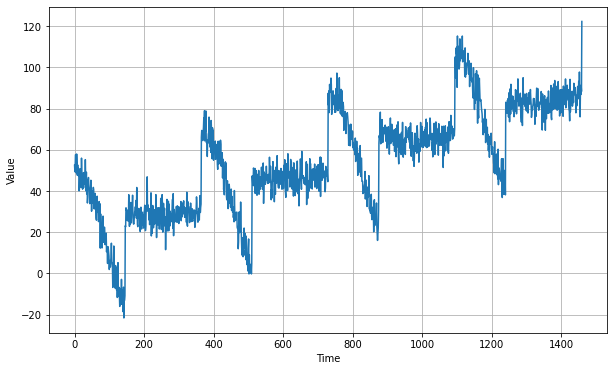

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, xlabel='Time', ylabel='Value')

# Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Prepare Features and Labels

In [5]:
# Parameters 
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  
  # Generate TF dataset from the series value
  dataset = tf.data.Dataset.from_tensor_slices(series)
  
  # Window the data but only take those with the specified size
  dataset = dataset.window(window_size +1, shift = 1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Create tuples with features and labels
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of winodws
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [7]:
# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Build the Model

* For time series data, we want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and strid. For a kernel size of 3 and of stride of 1, the window can be padded as such : [0, 0, 1, 2, 3, 4, 5]. [1] is still at t=0 and two zeros are prepended to simulate values in the past.
* This way, the first stride will be at [0, 0, 1] and tbis doesnot contain any future values when it is passed on to subsequent layers.

In [10]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 64,
                           kernel_size = 3,
                           strides = 1,
                           padding = "causal",
                           activation = "relu",
                           input_shape = [window_size,1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x* 400)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


# Tune the Learning Rate

In [11]:
# Get initial weights
init_weights = model.get_weights()

In [12]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * (10 ** (epoch)/20)
)

# Intialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

# Train the model
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
62/62 [==============================] - 6s 21ms/step - loss: 223.2638 - lr: 5.0000e-10
Epoch 2/100
62/62 [==============================] - 1s 20ms/step - loss: 206.5150 - lr: 5.0000e-09
Epoch 3/100
62/62 [==============================] - 1s 21ms/step - loss: 80.6428 - lr: 5.0000e-08
Epoch 4/100
62/62 [==============================] - 1s 21ms/step - loss: 8.4554 - lr: 5.0000e-07
Epoch 5/100
62/62 [==============================] - 1s 20ms/step - loss: 16.9074 - lr: 5.0000e-06
Epoch 6/100
62/62 [==============================] - 1s 20ms/step - loss: 50.3998 - lr: 5.0000e-05
Epoch 7/100
62/62 [==============================] - 1s 21ms/step - loss: 81.2687 - lr: 5.0000e-04
Epoch 8/100
62/62 [==============================] - 1s 21ms/step - loss: 1302.5104 - lr: 0.0050
Epoch 9/100
62/62 [==============================] - 1s 21ms/step - loss: 18900.6504 - lr: 0.0500
Epoch 10/100
62/62 [==============================] - 1s 21ms/step - loss: 173019.5938 - lr: 0.5000
Epoch 11/10

(1e-08, 0.001, 0.0, 50.0)

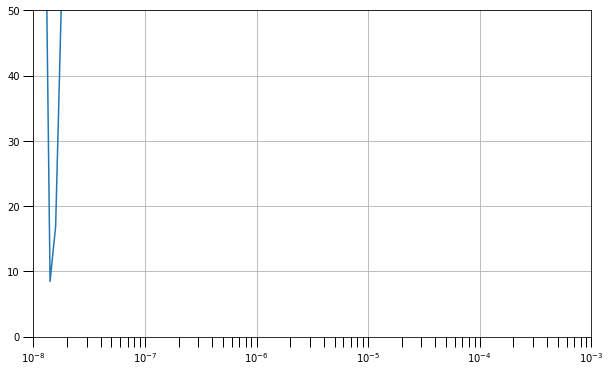

In [13]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100)/20))

# Set the figure size
plt.figure(figsize = (10,6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increate the tickmarks size
plt.tick_params('both', length = 10, width = 1, which = 'both')

# Set the axis boundaries
plt.axis([1e-8, 1e-3, 0, 50])

# Train the Model

In [14]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [15]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(
    learning_rate = learning_rate,
    momentum = 0.9
)

# Set the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

In [ ]:
# Train the model
history = model.fit(train_set, epochs = 500)